# Baseline Evaluation Walkthrough
This notebook demonstrates how Riley Inc. can launch a baseline Amazon Bedrock Eval job using the Nova Lite foundation model and the general text generation task type.

## Prerequisites
- AWS credentials configured for the account where evaluations will run.
- The IAM role `Amazon-Bedrock-IAM-Role-20250928T210855` with permissions to start Bedrock eval jobs and access the target S3 bucket.
- Python environment with the latest `boto3` and `botocore` libraries installed.


In [1]:
import json
from datetime import datetime
import boto3
from botocore.exceptions import BotoCoreError, ClientError
import re


## Configuration
Set your AWS Region, evaluation role, and S3 destination. Update `eval_results_bucket` to match the evaluation bucket provisioned in `00_infra_setup.ipynb`.

In [ ]:
aws_region = "us-west-2" # Update with your selected region
role_arn = "arn:aws:iam::187899929471:role/service-role/Amazon-Bedrock-IAM-Role-20250928T210855" # Update with your own role arn
model_id = "us.amazon.nova-lite-v1:0" # Update with your selected model id
eval_results_bucket = "riley-inc-rag-eval-results-20250929-210517"  # Paste the exact bucket name created in 00_infra_setup.ipynb
results_prefix = "baseline-evals/"
datasets = ["Builtin.T-REx"]
metrics = ["Builtin.Accuracy", "Builtin.Robustness"]
task_type = "Generation"
comparison_run_id = datetime.now().strftime('%Y%m%d-%H%M%S')
shared_output_uri = f"s3://{eval_results_bucket}/{results_prefix}comparison-run-{comparison_run_id}/"

if eval_results_bucket.endswith("REPLACE-ME"):
    raise ValueError("Update eval_results_bucket with the actual bucket name before running the notebook.")
if not datasets or not metrics:
    raise ValueError("Datasets and metrics must be non-empty lists.")

print(f"Evaluation artifacts will be stored under: {shared_output_uri}")
print(f"Datasets: {datasets}; metrics: {metrics}")


Evaluation artifacts will be stored under: s3://riley-inc-rag-eval-results-20250929-210517/baseline-evals/comparison-run-20250930-004722/
Datasets: ['Builtin.T-REx']; metrics: ['Builtin.Accuracy']


## Initialize Bedrock Client
Establish a client connection to Amazon Bedrock in the selected region.

In [3]:
bedrock = boto3.client("bedrock", region_name=aws_region)
print("Bedrock client ready.")

Bedrock client ready.


## Submit Baseline Eval Job
Create a general text generation evaluation job for the Nova Lite model using accuracy as the metric.

In [4]:

# Build a timestamped job name
job_name = f"baseline-eval-job-{datetime.now().strftime('%Y%m%d-%H%M%S')}"
output_uri = shared_output_uri
print(f"Creating evaluation job: {job_name} → {output_uri}")

dataset_metric_configs = [
    {
        'taskType': task_type,
        'dataset': {'name': dataset_name},
        'metricNames': metrics
    }
    for dataset_name in datasets
]

evaluation_request = {
    'jobName': job_name,
    'roleArn': role_arn,
    'evaluationConfig': {
        'automated': {
            'datasetMetricConfigs': dataset_metric_configs
        }
    },
    'inferenceConfig': {
        'models': [
            {
                'bedrockModel': {
                    'modelIdentifier': model_id
                }
            }
        ]
    },
    'outputDataConfig': {'s3Uri': output_uri}
}

try:
    create_response = bedrock.create_evaluation_job(**evaluation_request)
    print(json.dumps(create_response, indent=2))
except (ClientError, BotoCoreError) as err:
    raise RuntimeError('Failed to create evaluation job.') from err


Creating evaluation job: baseline-eval-job-20250930-004722 → s3://riley-inc-rag-eval-results-20250929-210517/baseline-evals/comparison-run-20250930-004722/
{
  "ResponseMetadata": {
    "RequestId": "5a1fad58-0b18-41a3-b3ad-a782439b933f",
    "HTTPStatusCode": 202,
    "HTTPHeaders": {
      "date": "Mon, 29 Sep 2025 16:47:24 GMT",
      "content-type": "application/json",
      "content-length": "79",
      "connection": "keep-alive",
      "x-amzn-requestid": "5a1fad58-0b18-41a3-b3ad-a782439b933f"
    },
    "RetryAttempts": 0
  },
  "jobArn": "arn:aws:bedrock:us-west-2:187899929471:evaluation-job/67332yzy8mfl"
}


## Check Job Status
Retrieve the evaluation job status to confirm that it is running.

In [5]:
job_arn = create_response.get("jobArn") or create_response.get("evaluationJobArn")
if not job_arn:
    raise ValueError("Could not find the job ARN in the create response.")

try:
    job_details = bedrock.get_evaluation_job(jobIdentifier=job_arn)
    print(json.dumps(job_details, indent=2, default=str))
except (ClientError, BotoCoreError) as err:
    raise RuntimeError("Unable to fetch evaluation job status.") from err

{
  "ResponseMetadata": {
    "RequestId": "1abf79a1-2418-4749-adef-e5d6fdf727e3",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "date": "Mon, 29 Sep 2025 16:47:24 GMT",
      "content-type": "application/json",
      "content-length": "1012",
      "connection": "keep-alive",
      "x-amzn-requestid": "1abf79a1-2418-4749-adef-e5d6fdf727e3"
    },
    "RetryAttempts": 0
  },
  "jobName": "baseline-eval-job-20250930-004722",
  "status": "InProgress",
  "jobArn": "arn:aws:bedrock:us-west-2:187899929471:evaluation-job/67332yzy8mfl",
  "roleArn": "arn:aws:iam::187899929471:role/service-role/Amazon-Bedrock-IAM-Role-20250928T210855",
  "jobType": "Automated",
  "applicationType": "ModelEvaluation",
  "evaluationConfig": {
    "automated": {
      "datasetMetricConfigs": [
        {
          "taskType": "Generation",
          "dataset": {
            "name": "Builtin.T-REx"
          },
          "metricNames": [
            "Builtin.Accuracy"
          ]
        }
      ]
    }
  }

## Automate Multi-Model Eval Launch
Define a helper that accepts model, task type, datasets, and metrics so you can spin up multiple evaluations with consistent settings.

In [6]:

def launch_eval_job(model_id: str, task_type: str, datasets: list, metrics: list):
    if not isinstance(datasets, list) or not datasets:
        raise ValueError('datasets must be a non-empty list of dataset names.')
    if not isinstance(metrics, list) or not metrics:
        raise ValueError('metrics must be a non-empty list of metric names.')

    dataset_metric_configs = [
        {
            'taskType': task_type,
            'dataset': {'name': dataset_name},
            'metricNames': metrics
        }
        for dataset_name in datasets
    ]

    sanitized_model = re.sub(r'[^a-zA-Z0-9-]+', '-', model_id.split('/')[-1])
    job_suffix = datetime.now().strftime('%Y%m%d-%H%M%S')
    job_name = f"baseline-eval-job-{sanitized_model}-{job_suffix}"
    output_uri = shared_output_uri

    request_payload = {
        'jobName': job_name,
        'roleArn': role_arn,
        'evaluationConfig': {
            'automated': {
                'datasetMetricConfigs': dataset_metric_configs
            }
        },
        'inferenceConfig': {
            'models': [
                {
                    'bedrockModel': {
                        'modelIdentifier': model_id
                    }
                }
            ]
        },
        'outputDataConfig': {
            's3Uri': output_uri
        }
    }

    try:
        response = bedrock.create_evaluation_job(**request_payload)
    except (ClientError, BotoCoreError) as err:
        raise RuntimeError(f'Failed to create evaluation job for {model_id}.') from err

    job_arn = response.get('jobArn') or response.get('evaluationJobArn')
    print(f"Launched {job_name} (model={model_id}) -> {job_arn}")
    return {
        'job_name': job_name,
        'job_arn': job_arn,
        'response': response
    }


## Launch Batch of Eval Jobs
Trigger three evaluations for different Nova-family models while reusing the same datasets and metrics.

In [7]:
candidate_models = [
    'us.amazon.nova-lite-v1:0',
    'us.amazon.nova-micro-v1:0',
]

task_type = 'Generation'
datasets = ["Builtin.T-REx"]
metrics = ["Builtin.Accuracy", "Builtin.Robustness"]

batch_jobs = []
for candidate_model in candidate_models:
    job_info = launch_eval_job(
        model_id=candidate_model,
        task_type=task_type,
        datasets=datasets,
        metrics=metrics
    )
    batch_jobs.append(job_info)

print(json.dumps(batch_jobs, indent=2, default=str))


Launched baseline-eval-job-us-amazon-nova-lite-v1-0-20250930-004724 (model=us.amazon.nova-lite-v1:0) -> arn:aws:bedrock:us-west-2:187899929471:evaluation-job/nvty69b439h9
Launched baseline-eval-job-us-amazon-nova-micro-v1-0-20250930-004725 (model=us.amazon.nova-micro-v1:0) -> arn:aws:bedrock:us-west-2:187899929471:evaluation-job/1ol66tf3ns0i
[
  {
    "job_name": "baseline-eval-job-us-amazon-nova-lite-v1-0-20250930-004724",
    "job_arn": "arn:aws:bedrock:us-west-2:187899929471:evaluation-job/nvty69b439h9",
    "response": {
      "ResponseMetadata": {
        "RequestId": "6dd1e04c-3c62-4bc1-95fe-fc3853c9c9ca",
        "HTTPStatusCode": 202,
        "HTTPHeaders": {
          "date": "Mon, 29 Sep 2025 16:47:25 GMT",
          "content-type": "application/json",
          "content-length": "79",
          "connection": "keep-alive",
          "x-amzn-requestid": "6dd1e04c-3c62-4bc1-95fe-fc3853c9c9ca"
        },
        "RetryAttempts": 0
      },
      "jobArn": "arn:aws:bedrock:us-wes

## Compare Evaluation Jobs
Once evaluation jobs complete, use the shared results prefix to compare model performance side-by-side. The cells below gather job metadata and load aggregated metrics from Amazon S3.


### Gather Job Metadata
Collect the job ARNs and names you want to compare. This uses the baseline run plus any batch jobs launched earlier.


In [8]:
comparison_jobs = []

if 'create_response' in globals():
    comparison_jobs.append({
        'job_name': evaluation_request['jobName'],
        'job_arn': create_response.get('jobArn') or create_response.get('evaluationJobArn')
    })

if 'batch_jobs' in globals() and batch_jobs:
    comparison_jobs.extend([
        {'job_name': job['job_name'], 'job_arn': job['job_arn']}
        for job in batch_jobs
    ])

if not comparison_jobs:
    raise ValueError('No evaluation jobs recorded yet. Launch at least one job before running comparisons.')

for job in comparison_jobs:
    print(f"- {job['job_name']} -> {job['job_arn']}")


- baseline-eval-job-20250930-004722 -> arn:aws:bedrock:us-west-2:187899929471:evaluation-job/67332yzy8mfl
- baseline-eval-job-us-amazon-nova-lite-v1-0-20250930-004724 -> arn:aws:bedrock:us-west-2:187899929471:evaluation-job/nvty69b439h9
- baseline-eval-job-us-amazon-nova-micro-v1-0-20250930-004725 -> arn:aws:bedrock:us-west-2:187899929471:evaluation-job/1ol66tf3ns0i


### Load Aggregated Metrics from S3
The helper below lists objects under the shared output prefix, searches for aggregated metric files, and builds a comparison table. Jobs still in progress or without published metrics are skipped.


In [13]:

import pandas as pd
from urllib.parse import urlparse
from collections import defaultdict

s3 = boto3.client('s3', region_name=aws_region)

parsed_uri = urlparse(shared_output_uri)
results_bucket = parsed_uri.netloc
results_prefix = parsed_uri.path.lstrip('/')

def iter_result_keys(bucket: str, prefix: str):
    paginator = s3.get_paginator('list_objects_v2')
    for page in paginator.paginate(Bucket=bucket, Prefix=prefix):
        for obj in page.get('Contents', []):
            yield obj['Key']

def load_aggregated_metrics(job_name: str):
    prefix = f"{results_prefix}{job_name}/"
    keys = list(iter_result_keys(results_bucket, prefix))
    if not keys:
        return None, None

    aggregated_keys = [key for key in keys if key.endswith('aggregated-metrics.json')]
    if not aggregated_keys:
        aggregated_keys = [key for key in keys if key.endswith('metrics.json')]

    for key in aggregated_keys:
        body = s3.get_object(Bucket=results_bucket, Key=key)['Body'].read()
        try:
            data = json.loads(body)
        except json.JSONDecodeError:
            continue
        metrics = {}
        if isinstance(data, dict):
            for metric_name, metric_value in data.items():
                if isinstance(metric_value, (int, float)):
                    metrics[metric_name] = metric_value
                elif isinstance(metric_value, dict) and 'value' in metric_value:
                    value = metric_value.get('value')
                    if isinstance(value, (int, float)):
                        metrics[metric_name] = value
        if metrics:
            return metrics, key

    jsonl_keys = [key for key in keys if key.endswith('_output.jsonl')]
    for key in jsonl_keys:
        body_stream = s3.get_object(Bucket=results_bucket, Key=key)['Body']
        totals = defaultdict(float)
        counts = defaultdict(int)
        for raw_line in body_stream.iter_lines():
            if not raw_line:
                continue
            try:
                record = json.loads(raw_line)
            except json.JSONDecodeError:
                continue
            scores = record.get('automatedEvaluationResult', {}).get('scores', [])
            for score in scores:
                metric_name = score.get('metricName')
                metric_value = score.get('result')
                if metric_name and isinstance(metric_value, (int, float)):
                    totals[metric_name] += metric_value
                    counts[metric_name] += 1
        if counts:
            metrics = {metric: totals[metric] / counts[metric] for metric in totals}
            metrics['recordsEvaluated'] = max(counts.values())
            return metrics, key

    return None, None


comparison_rows = []
for job in comparison_jobs:
    metrics, source_key = load_aggregated_metrics(job['job_name'])
    if not metrics:
        print(f"No aggregated metrics yet for {job['job_name']} (check job status or output files manually).")
        continue
    row = {
        'job_name': job['job_name'],
        'job_arn': job['job_arn'],
        'metrics_source': source_key,
    }
    row.update(metrics)
    comparison_rows.append(row)

if not comparison_rows:
    raise RuntimeError('No metrics available to compare yet. Re-run after the jobs finish.')

comparison_df = pd.DataFrame(comparison_rows)
comparison_df.set_index('job_name', inplace=True)
display(comparison_df)


,job_arn,metrics_source,Builtin.Accuracy,recordsEvaluated,Builtin.Robustness
job_name,,,,,
baseline-eval-job-20250930-004722,arn:aws:bedrock:us-west-2:187899929471:evaluat...,baseline-evals/comparison-run-20250930-004722/...,0.53,100,NaN
baseline-eval-job-us-amazon-nova-lite-v1-0-20250930-004724,arn:aws:bedrock:us-west-2:187899929471:evaluat...,baseline-evals/comparison-run-20250930-004722/...,0.52,100,4.559676
baseline-eval-job-us-amazon-nova-micro-v1-0-20250930-004725,arn:aws:bedrock:us-west-2:187899929471:evaluat...,baseline-evals/comparison-run-20250930-004722/...,0.37,100,4.325739


### Visualize Metrics
Use simple charts to highlight how each model performed across key metrics.

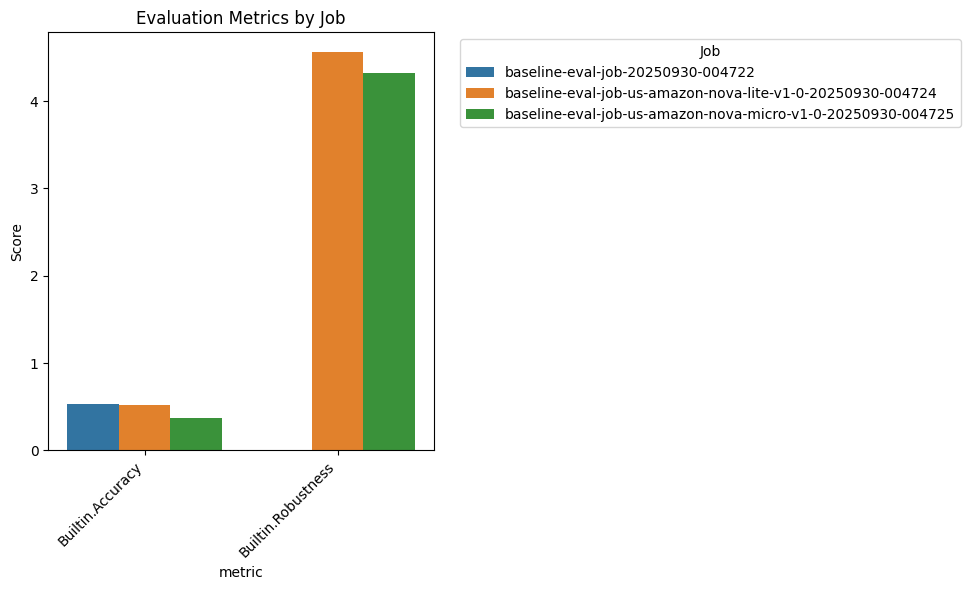

In [14]:

import matplotlib.pyplot as plt
import seaborn as sns

metric_columns = [col for col in comparison_df.columns if col not in ('job_arn', 'metrics_source', 'recordsEvaluated')]
if not metric_columns:
    raise ValueError('No metric columns found in comparison_df to visualize.')

melted = comparison_df.reset_index().melt(id_vars=['job_name'], value_vars=metric_columns, var_name='metric', value_name='score')

plt.figure(figsize=(10, 6))
sns.barplot(data=melted, x='metric', y='score', hue='job_name')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Score')
plt.title('Evaluation Metrics by Job')
plt.legend(title='Job', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## Next Steps
- Monitor the job until it reaches a terminal state (`Completed`, `Failed`, or `Stopped`).
- Review the metrics and detailed outputs stored in the S3 results prefix.
- Iterate on prompts, models, or datasets as needed to improve baseline quality.